In [1]:
import pandas as pd
import os  

import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
path_data = '../data/raw/ai4i2020.csv'
df_ai4i = pd.read_csv(path_data, sep=',', encoding='utf-8')

In [3]:
df_ai4i.head()  # Display the first few rows of the dataframe

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### 1. Fundamental exploere dataset, chceck nulls and outliers 

In [4]:
df_ai4i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

Kolumna	Opis
UDI	Unique Identifier – ID rekordu (nieistotne dla predykcji)
<br>
Product ID	Unikalny identyfikator produktu (np. M14860) – kategoryczny
<br>
Type	Typ produktu: L, M, H (Low, Medium, High) – kategoria
<br>
Air temperature [K]	Temperatura otoczenia w kelwinach (z czujnika)
<br>
Process temperature [K]	Temperatura procesu (np. obrabianego elementu) – zwykle wyższa niż Air temp
<br>
Rotational speed [rpm]	Prędkość obrotowa maszyny (obr./min)
<br>
Torque [Nm]	Moment obrotowy – siła skrętu (w niutonometrach)
<br>
Tool wear [min]	Czas pracy narzędzia – zużycie (w minutach)
<br>
Machine failure	Target: 1 = wystąpiła awaria, 0 = brak awarii
<br>
TWF	Tool Wear Failure – awaria z powodu zużycia narzędzia
<br>
HDF	Heat Dissipation Failure – awaria z powodu przegrzania
<br>
PWF	Power Failure – awaria zasilania
<br>
OSF	Overstrain Failure – awaria z powodu przeciążenia
<br>
RNF	Random Failure – losowa awaria

Datase dont have any NULL values. After that when start check outliers values. 

### 2. Checking outliers values 

In [5]:
cols = [col for col in df_ai4i.columns
        if pd.api.types.is_numeric_dtype(df_ai4i[col])
        and df_ai4i[col].nunique() > 10
        and col not in ['UDI', 'Machine failure']]

# Parametry siatki
n = len(cols)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

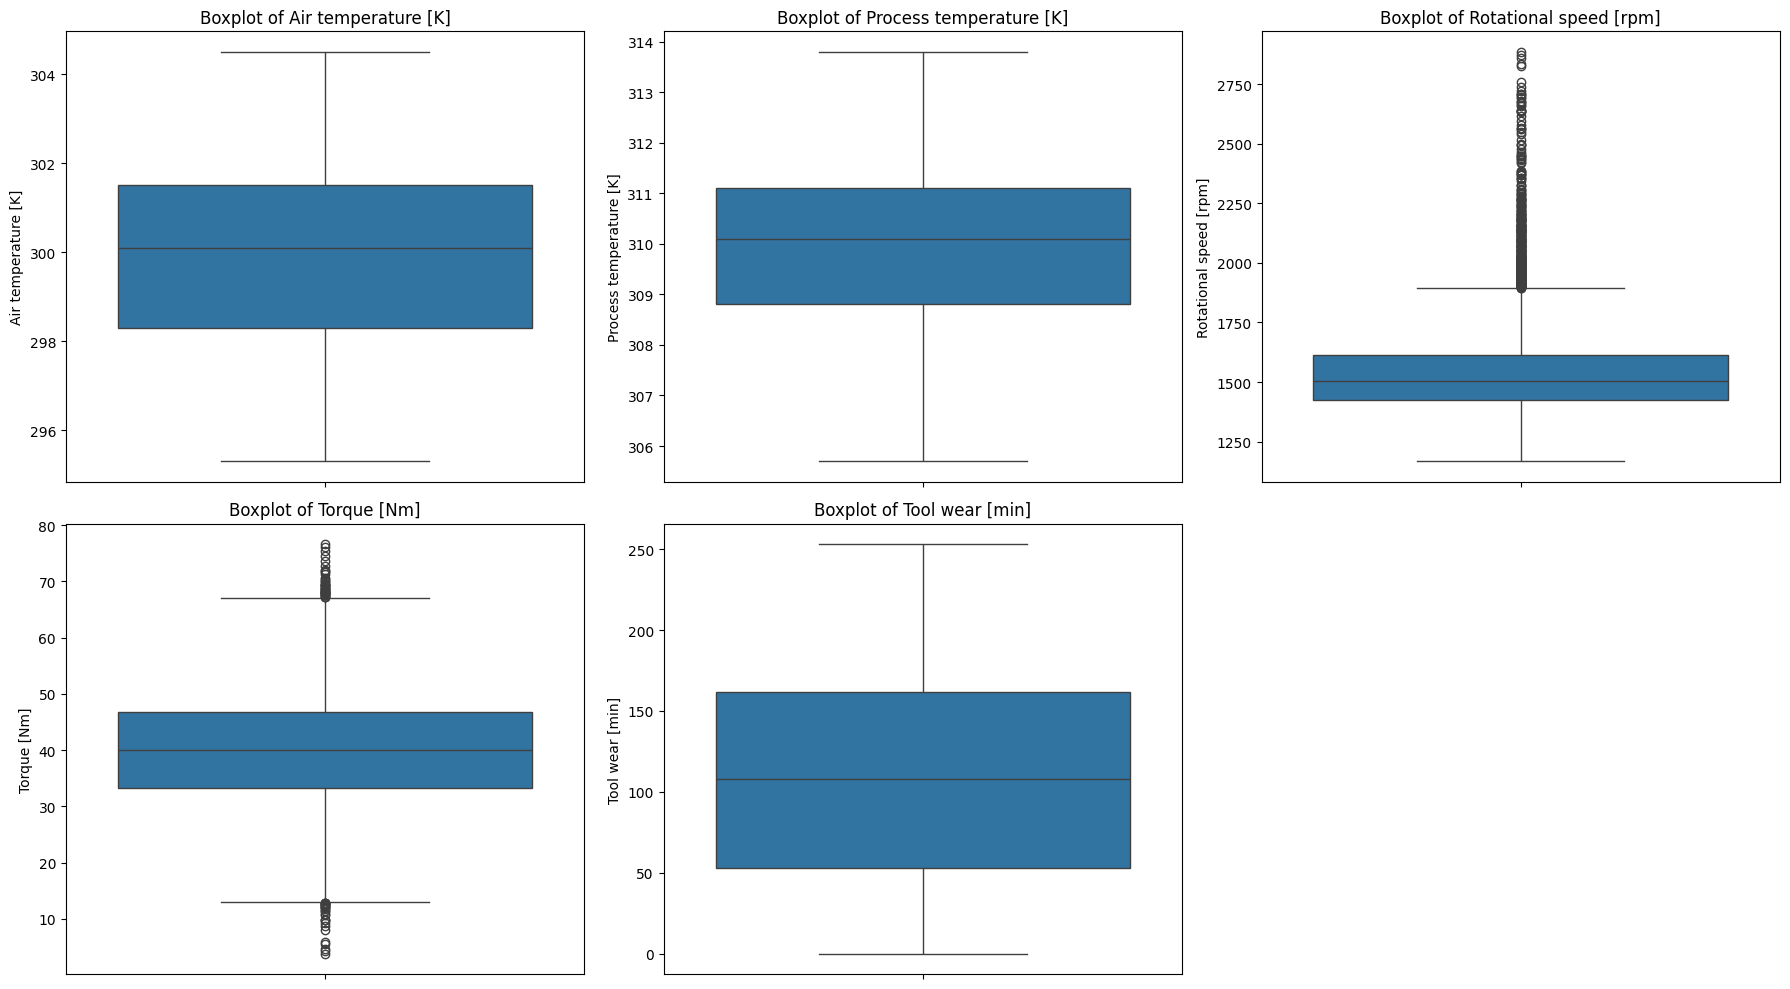

In [7]:
fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(6 * cols_per_row, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(data=df_ai4i, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)

# Usuwanie pustych osi jeśli trzeba
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


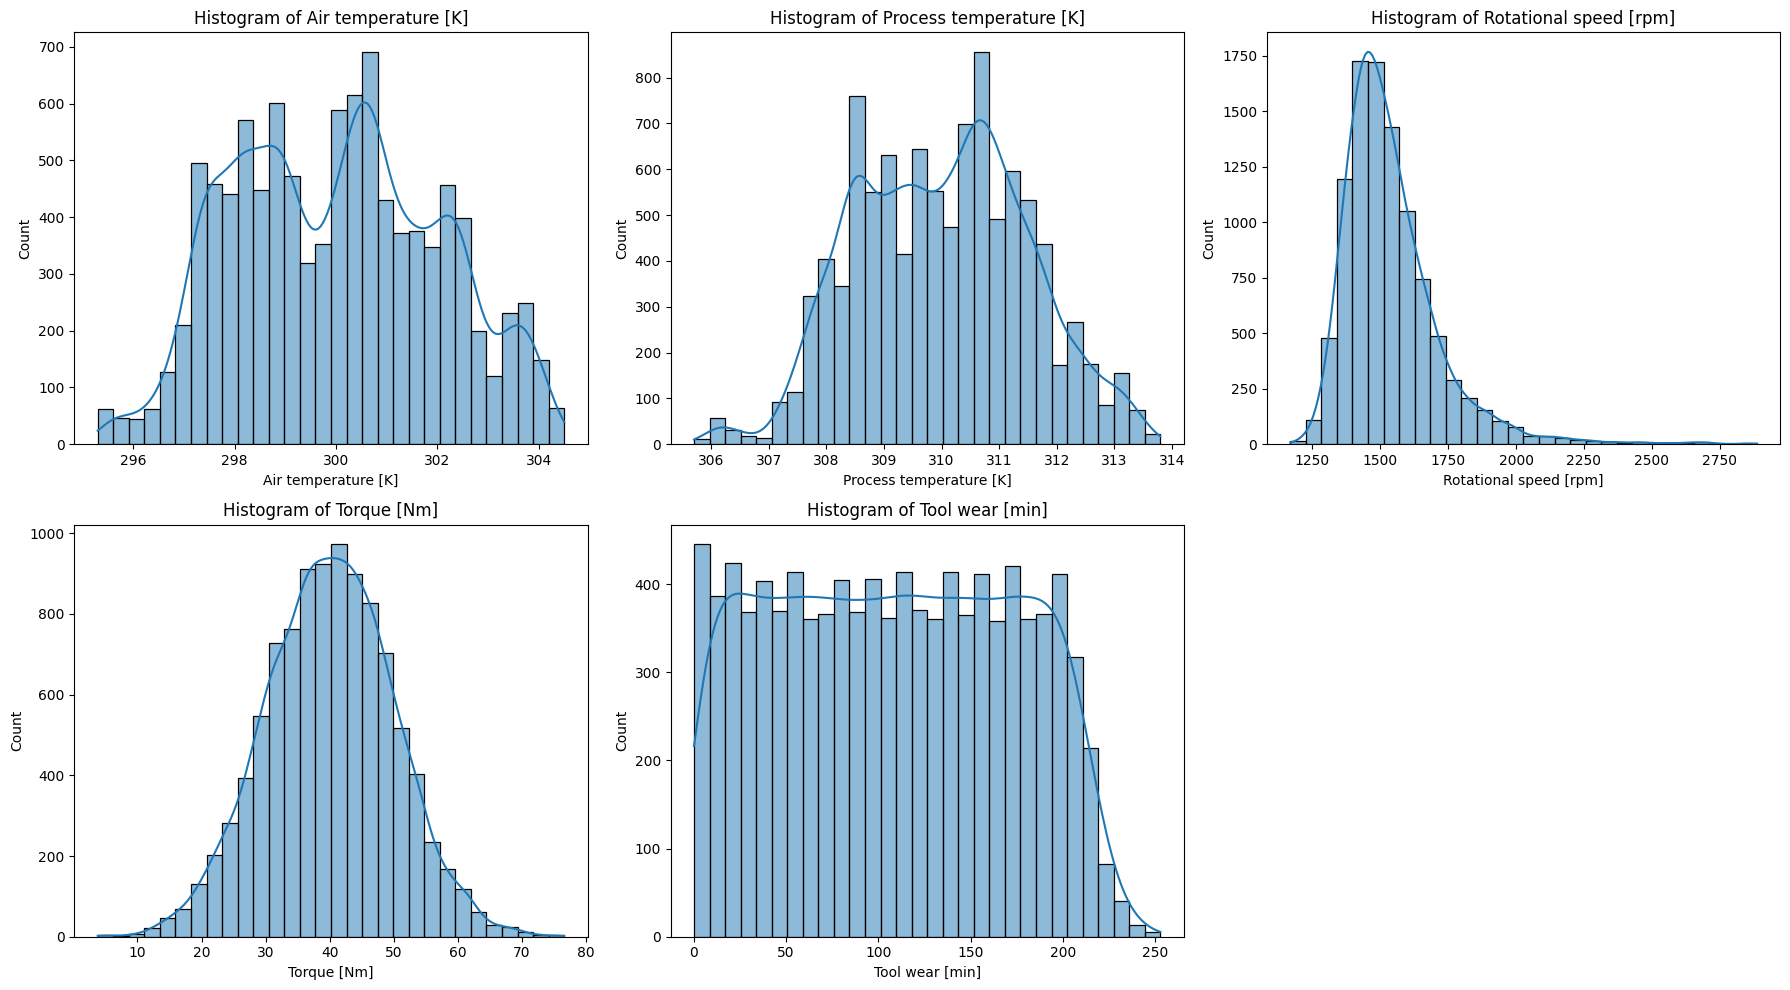

In [8]:
fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(6 * cols_per_row, 5 * rows))
axes = axes.flatten()

# Rysowanie histogramów
for i, col in enumerate(cols):
    sns.histplot(data=df_ai4i, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Usuwanie pustych osi
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

zarówno moment obrotowy jak i prędkość obrotu maszyny posiadają wartości odstające. Najprawdopodobniej mogą one wynikać z awarii. Należałoby zestawić te wartości oborotwe z kolumnami awarii, czy faktycznie jak moment obrotowy spada to mamy do czynienia z awarią 

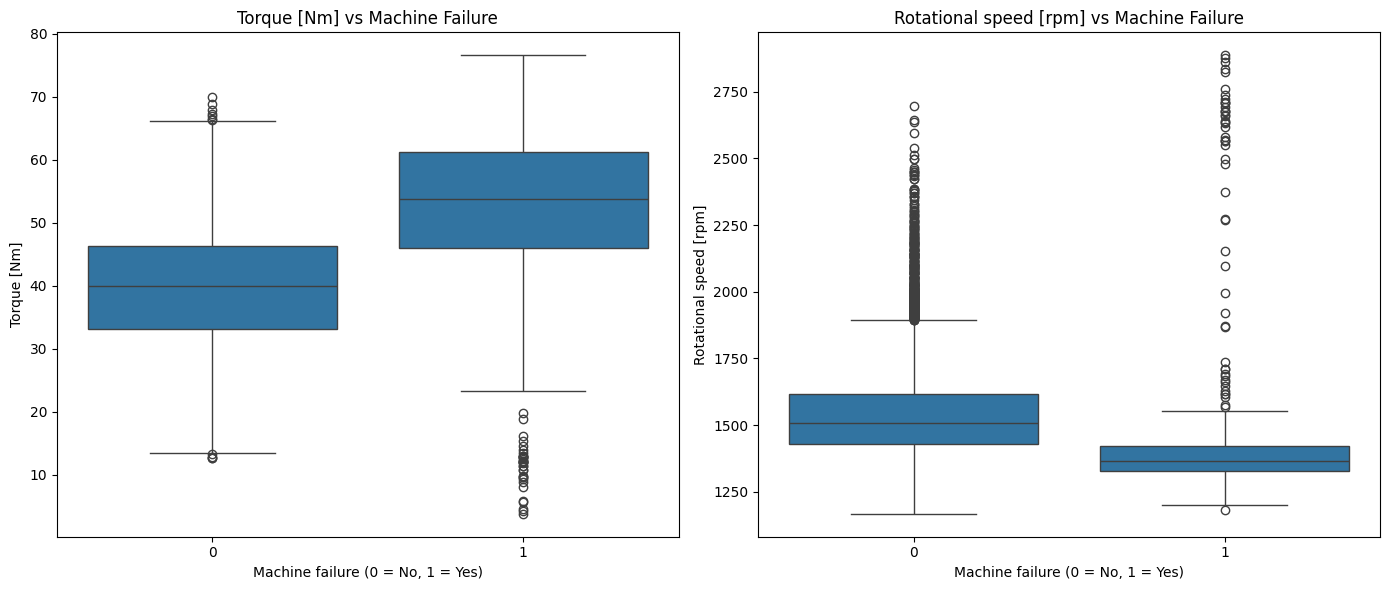

In [9]:
cols = ['Torque [Nm]', 'Rotational speed [rpm]']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, col in enumerate(cols):
    sns.boxplot(data=df_ai4i, x='Machine failure', y=col, ax=axes[i])
    axes[i].set_title(f'{col} vs Machine Failure')
    axes[i].set_xlabel('Machine failure (0 = No, 1 = Yes)')

plt.tight_layout()
plt.show()

Boxploty:
Torque [Nm]:

Dla klasy Machine failure = 1 (awaria) wartości momentu obrotowego są znacząco niższe niż dla klasy 0.

Występują wyraźne outliery, które mogą być efektem nieprawidłowego działania maszyny.

Możliwe, że spadek momentu obrotowego jest sygnałem awarii.

Rotational Speed [rpm]:

Różnica między klasami jest mniej wyraźna.

Klasa 1 (awaria) ma dłuższy ogon outlierów, ale outliery występują również licznie w klasie 0.

Sama obecność wysokiej prędkości nie jest wystarczająca do jednoznacznego wskazania awarii.

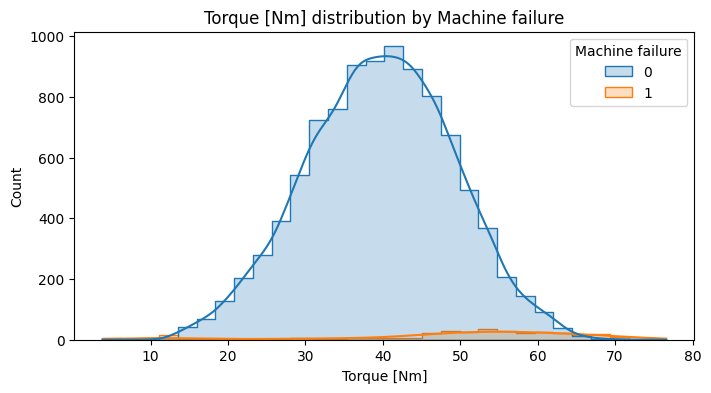

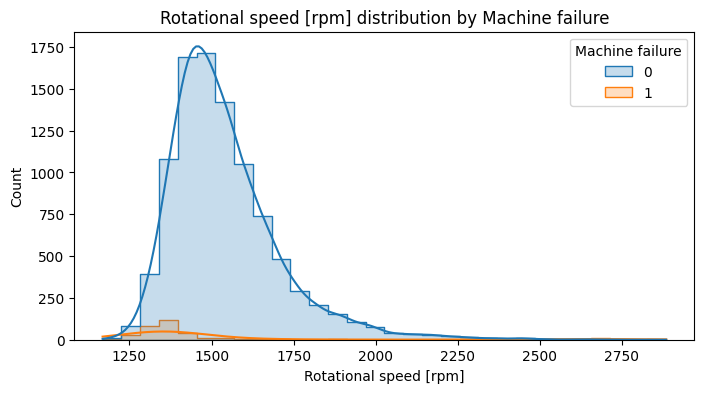

In [10]:
for col in cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_ai4i, x=col, hue='Machine failure', kde=True, bins=30, element='step')
    plt.title(f'{col} distribution by Machine failure')
    plt.show()

Histogramy z podziałem na klasy:
Torque [Nm]:

Klasa 1 skupia się głównie w zakresie 50–70 Nm, co sugeruje, że większość awarii występuje przy wyższych wartościach momentu (co z kolei może oznaczać nadmierne obciążenie).

Klasa 0 (brak awarii) ma rozkład bardziej symetryczny i szerszy.

Rotational Speed [rpm]:

Dla klasy 1 obserwujemy koncentrację w zakresie 1250–1500 rpm, czyli przy niższych prędkościach obrotowych częściej dochodzi do awarii.

Może to oznaczać, że spadek prędkości jest objawem problemów technicznych.